Model From https://github.com/fxia22/pointnet.pytorch/blob/master/pointnet/model.py

In [1]:
!git clone https://github.com/weidezhang/pypcd_python3.6.git pypcd_hack

fatal: destination path 'pypcd_hack' already exists and is not an empty directory.


In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

In [3]:
#batch, dim, npoints
sim_data = Variable(torch.rand(32,3,500))
print(sim_data.shape)


torch.Size([32, 3, 500])


(8, 8, 3)


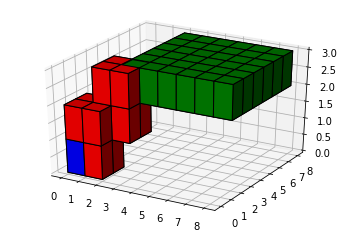

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


# prepare some coordinates
x, y, z = np.indices((8, 8, 3))

# draw cuboids in the top left and bottom right corners, and a link between them
cube1 = (x < 1) & (y < 1) & (z < 1)
cube2 = (x >= 2) & (y >= 2) & (z >= 2)
link = abs(x - y) + abs(y - z) + abs(z - x) <= 2

# combine the objects into a single boolean array
voxels = cube1 | cube2 | link

# set the colors of each object
colors = np.empty(voxels.shape, dtype=object)
colors[link] = 'red'
colors[cube1] = 'blue'
colors[cube2] = 'green'
print(colors.shape)

# and plot everything
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(voxels, facecolors=colors, edgecolor='k')

plt.show()

https://github.com/meder411/PointNet-PyTorch/blob/master/models/transformer.py

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as grad



class TransformationNet(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(TransformationNet, self).__init__()
        self.output_dim = output_dim

        self.conv_1 = nn.Conv1d(input_dim, 64, 1)
        self.conv_2 = nn.Conv1d(64, 128, 1)
        self.conv_3 = nn.Conv1d(128, 1024, 1)

        self.bn_1 = nn.BatchNorm1d(64)
        self.bn_2 = nn.BatchNorm1d(128)
        self.bn_3 = nn.BatchNorm1d(1024)
        self.bn_4 = nn.BatchNorm1d(512)
        self.bn_5 = nn.BatchNorm1d(256)

        self.fc_1 = nn.Linear(1024, 512)
        self.fc_2 = nn.Linear(512, 256)
        self.fc_3 = nn.Linear(256, self.output_dim*self.output_dim)

    def forward(self, x):
        num_points = x.shape[1]
        x = x.transpose(2, 1)
        x = F.relu(self.bn_1(self.conv_1(x)))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = F.relu(self.bn_3(self.conv_3(x)))

        x = nn.MaxPool1d(num_points)(x)
        x = x.view(-1, 1024)

        x = F.relu(self.bn_4(self.fc_1(x)))
        x = F.relu(self.bn_5(self.fc_2(x)))
        x = self.fc_3(x)

        identity_matrix = torch.eye(self.output_dim)
        if torch.cuda.is_available():
            identity_matrix = identity_matrix.cuda()
        x = x.view(-1, self.output_dim, self.output_dim) + identity_matrix
        return x

##-----------------------------------------------------------------------------
# Class for Transformer. Subclasses PyTorch's own "nn" module
#
# Computes a KxK affine transform from the input data to transform inputs
# to a "canonical view"
##
class Transformer(nn.Module):
    def __init__(self, num_points=2000, K=3):
        # Call the super constructor
        print (num_points, K)
        super(Transformer, self).__init__()

        # Number of dimensions of the data
        self.K = K

        # Size of input
        self.N = num_points
        if num_points < 201:
            print ("this will fail too small resize to minimum of 201")
            self.N = 201

        # Initialize identity matrix on the GPU (do this here so it only 
        # happens once)
        self.identity = grad.Variable(
            torch.eye(self.K).double().view(-1).cuda())

        # First embedding block
        self.block1 =nn.Sequential(
            nn.Conv1d(K, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU())

        # Second embedding block
        self.block2 =nn.Sequential(
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU())

        # Third embedding block
        self.block3 =nn.Sequential(
            nn.Conv1d(128, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU())

        # Multilayer perceptron
        self.mlp = nn.Sequential(
            nn.Linear(64, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, K * K))


    # Take as input a B x K x N matrix of B batches of N points with K 
    # dimensions
    def forward(self, x):

        # Compute the feature extractions
        # Output should ultimately be B x 1024 x N
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        # Pool over the number of points
        # Output should be B x 1024 x 1 --> B x 1024 (after squeeze)
        x = F.max_pool1d(x, self.N).squeeze(2)
        # Run the pooled features through the multi-layer perceptron
        # Output should be B x K^2
        x = self.mlp(x)

        # Add identity matrix to transform
        # Output is still B x K^2 (broadcasting takes care of batch dimension)
        x += self.identity

        # Reshape the output into B x K x K affine transformation matrices
        x = x.view(-1, self.K, self.K)
        return x


In [6]:
K = 8
sim_data = Variable(torch.rand(10,K,400)).cuda()
sim_data2 = Variable(torch.rand(10,K,350)).cuda()
t = Transformer(num_points=201, K=K).cuda()
t(sim_data2).shape

201 8


torch.Size([10, 8, 8])

In [7]:
#t(sim_data2).shape

In [8]:
#sim_data = Variable(torch.rand(32,3,4000)).cuda()
#t = Transformer(num_points=2500, K=3).cuda()
#t(sim_data).shape

### Source https://discuss.pytorch.org/t/which-part-of-pytorch-tensor-represents-channels/21778
The first number represents the Batchsize (N) and for tensors holding data of a dimension of 1 or above the next dimension is usually referred to as channel-dimension. The following dimensions are commonly height, width and depth.
So for 2d data (images) you have a 4d tensor of NxCxHxW which you feed into a 2d conv layer.

Note that channels only exist for convolutional layers. Linear layers for example need a shape of N x #num_features

In [9]:
import pandas as pd
import numpy as np

In [10]:
df = pd.read_csv("/media/person_data.csv")
df.head()

,OriginalID,Stamp,LabeledId,MeanX,MreanY,MeanZ,MeanI,VarX,VarY,VarZ,VarI,RangeX,RangeY,RangeZ,RangeI,SafetyIndex
0,person_BGV160,1.593697e+18,person_CHW026,2.16070,-1.51747,0.009536,25.7358,0.017539,0.008052,0.070805,161.762,0.580519,0.501747,0.962191,53,691.907
1,person_BGV160,1.593697e+18,person_CHW026,2.10568,-1.42697,0.000821,26.6586,0.016780,0.010158,0.067378,157.341,0.549305,0.558436,0.929846,53,691.907
2,person_BGV160,1.593697e+18,person_CHW026,2.04742,-1.34319,0.001883,25.0231,0.031696,0.012176,0.077002,185.470,1.073560,0.886896,1.049920,53,691.907
3,person_BGV160,1.593697e+18,person_CHW026,2.03730,-1.27878,0.030707,25.9707,0.024252,0.008819,0.073974,148.507,1.022480,0.517114,1.006430,52,691.907
4,person_BGV160,1.593697e+18,person_CHW026,2.00939,-1.23015,0.018220,26.5070,0.022890,0.009475,0.086418,155.662,0.981035,0.661598,1.103300,53,1251.220


In [11]:
df = df.loc[:,["OriginalID","Stamp", "SafetyIndex"]]

In [12]:
df["Stamp"] = df["Stamp"].round().astype(np.uint64)
df

,OriginalID,Stamp,SafetyIndex
0,person_BGV160,1593697069265969920,691.907
1,person_BGV160,1593697069651310080,691.907
2,person_BGV160,1593697070272859904,691.907
3,person_BGV160,1593697070662200064,691.907
4,person_BGV160,1593697071273590016,1251.220
...,...,...,...
2319,person_ZGH580,1593792746947930112,1200.240
2320,person_ZGH580,1593792747544580096,1200.240
2321,person_ZGH580,1593792756543450112,1200.240
2322,person_ZGH580,1593792756743529984,1200.240


In [13]:
df["FStamp"] = df["Stamp"].floordiv(1000000)
df

,OriginalID,Stamp,SafetyIndex,FStamp
0,person_BGV160,1593697069265969920,691.907,1593697069265
1,person_BGV160,1593697069651310080,691.907,1593697069651
2,person_BGV160,1593697070272859904,691.907,1593697070272
3,person_BGV160,1593697070662200064,691.907,1593697070662
4,person_BGV160,1593697071273590016,1251.220,1593697071273
...,...,...,...,...
2319,person_ZGH580,1593792746947930112,1200.240,1593792746947
2320,person_ZGH580,1593792747544580096,1200.240,1593792747544
2321,person_ZGH580,1593792756543450112,1200.240,1593792756543
2322,person_ZGH580,1593792756743529984,1200.240,1593792756743


In [14]:
import os


def find_file(folder, needle):
    directory = os.listdir(folder)
    for fname in directory:
        if needle in fname:
            #print('found string in file %s' % fname)
            return folder+fname
    return None

In [15]:
import os
PATH = "/media/datasets/persons_pcd/"

df['needle'] = df.OriginalID.str.cat("*"+df.FStamp.astype(str))
df
#batch = df.iloc[[0,100]]
#print (batch["OriginalID"].tolist()  batch["Stamp"].tolist())
#files = os.path.join(PATH, (batch["OriginalID"]+str(batch["Stamp"])).to_string())

#files


,OriginalID,Stamp,SafetyIndex,FStamp,needle
0,person_BGV160,1593697069265969920,691.907,1593697069265,person_BGV160*1593697069265
1,person_BGV160,1593697069651310080,691.907,1593697069651,person_BGV160*1593697069651
2,person_BGV160,1593697070272859904,691.907,1593697070272,person_BGV160*1593697070272
3,person_BGV160,1593697070662200064,691.907,1593697070662,person_BGV160*1593697070662
4,person_BGV160,1593697071273590016,1251.220,1593697071273,person_BGV160*1593697071273
...,...,...,...,...,...
2319,person_ZGH580,1593792746947930112,1200.240,1593792746947,person_ZGH580*1593792746947
2320,person_ZGH580,1593792747544580096,1200.240,1593792747544,person_ZGH580*1593792747544
2321,person_ZGH580,1593792756543450112,1200.240,1593792756543,person_ZGH580*1593792756543
2322,person_ZGH580,1593792756743529984,1200.240,1593792756743,person_ZGH580*1593792756743


In [16]:
df['class'], df['id'] = df['OriginalID'].str.split('_', 1).str
df

,OriginalID,Stamp,SafetyIndex,FStamp,needle,class,id
0,person_BGV160,1593697069265969920,691.907,1593697069265,person_BGV160*1593697069265,person,BGV160
1,person_BGV160,1593697069651310080,691.907,1593697069651,person_BGV160*1593697069651,person,BGV160
2,person_BGV160,1593697070272859904,691.907,1593697070272,person_BGV160*1593697070272,person,BGV160
3,person_BGV160,1593697070662200064,691.907,1593697070662,person_BGV160*1593697070662,person,BGV160
4,person_BGV160,1593697071273590016,1251.220,1593697071273,person_BGV160*1593697071273,person,BGV160
...,...,...,...,...,...,...,...
2319,person_ZGH580,1593792746947930112,1200.240,1593792746947,person_ZGH580*1593792746947,person,ZGH580
2320,person_ZGH580,1593792747544580096,1200.240,1593792747544,person_ZGH580*1593792747544,person,ZGH580
2321,person_ZGH580,1593792756543450112,1200.240,1593792756543,person_ZGH580*1593792756543,person,ZGH580
2322,person_ZGH580,1593792756743529984,1200.240,1593792756743,person_ZGH580*1593792756743,person,ZGH580


In [17]:
df["path"] = PATH + df["id"] + "/"
df

,OriginalID,Stamp,SafetyIndex,FStamp,needle,class,id,path
0,person_BGV160,1593697069265969920,691.907,1593697069265,person_BGV160*1593697069265,person,BGV160,/media/datasets/persons_pcd/BGV160/
1,person_BGV160,1593697069651310080,691.907,1593697069651,person_BGV160*1593697069651,person,BGV160,/media/datasets/persons_pcd/BGV160/
2,person_BGV160,1593697070272859904,691.907,1593697070272,person_BGV160*1593697070272,person,BGV160,/media/datasets/persons_pcd/BGV160/
3,person_BGV160,1593697070662200064,691.907,1593697070662,person_BGV160*1593697070662,person,BGV160,/media/datasets/persons_pcd/BGV160/
4,person_BGV160,1593697071273590016,1251.220,1593697071273,person_BGV160*1593697071273,person,BGV160,/media/datasets/persons_pcd/BGV160/
...,...,...,...,...,...,...,...,...
2319,person_ZGH580,1593792746947930112,1200.240,1593792746947,person_ZGH580*1593792746947,person,ZGH580,/media/datasets/persons_pcd/ZGH580/
2320,person_ZGH580,1593792747544580096,1200.240,1593792747544,person_ZGH580*1593792747544,person,ZGH580,/media/datasets/persons_pcd/ZGH580/
2321,person_ZGH580,1593792756543450112,1200.240,1593792756543,person_ZGH580*1593792756543,person,ZGH580,/media/datasets/persons_pcd/ZGH580/
2322,person_ZGH580,1593792756743529984,1200.240,1593792756743,person_ZGH580*1593792756743,person,ZGH580,/media/datasets/persons_pcd/ZGH580/


In [18]:
df["filenames"] = df.apply(lambda row: find_file(row.path, row.needle), axis=1)
df

,OriginalID,Stamp,SafetyIndex,FStamp,needle,class,id,path,filenames
0,person_BGV160,1593697069265969920,691.907,1593697069265,person_BGV160*1593697069265,person,BGV160,/media/datasets/persons_pcd/BGV160/,/media/datasets/persons_pcd/BGV160/person_BGV1...
1,person_BGV160,1593697069651310080,691.907,1593697069651,person_BGV160*1593697069651,person,BGV160,/media/datasets/persons_pcd/BGV160/,/media/datasets/persons_pcd/BGV160/person_BGV1...
2,person_BGV160,1593697070272859904,691.907,1593697070272,person_BGV160*1593697070272,person,BGV160,/media/datasets/persons_pcd/BGV160/,/media/datasets/persons_pcd/BGV160/person_BGV1...
3,person_BGV160,1593697070662200064,691.907,1593697070662,person_BGV160*1593697070662,person,BGV160,/media/datasets/persons_pcd/BGV160/,/media/datasets/persons_pcd/BGV160/person_BGV1...
4,person_BGV160,1593697071273590016,1251.220,1593697071273,person_BGV160*1593697071273,person,BGV160,/media/datasets/persons_pcd/BGV160/,/media/datasets/persons_pcd/BGV160/person_BGV1...
...,...,...,...,...,...,...,...,...,...
2319,person_ZGH580,1593792746947930112,1200.240,1593792746947,person_ZGH580*1593792746947,person,ZGH580,/media/datasets/persons_pcd/ZGH580/,/media/datasets/persons_pcd/ZGH580/person_ZGH5...
2320,person_ZGH580,1593792747544580096,1200.240,1593792747544,person_ZGH580*1593792747544,person,ZGH580,/media/datasets/persons_pcd/ZGH580/,/media/datasets/persons_pcd/ZGH580/person_ZGH5...
2321,person_ZGH580,1593792756543450112,1200.240,1593792756543,person_ZGH580*1593792756543,person,ZGH580,/media/datasets/persons_pcd/ZGH580/,/media/datasets/persons_pcd/ZGH580/person_ZGH5...
2322,person_ZGH580,1593792756743529984,1200.240,1593792756743,person_ZGH580*1593792756743,person,ZGH580,/media/datasets/persons_pcd/ZGH580/,/media/datasets/persons_pcd/ZGH580/person_ZGH5...


In [19]:
data = df[['filenames', 'SafetyIndex']].copy()
del df

In [20]:
data = data.dropna()

In [21]:
def get_batchfilenames_from_data(start_index, end_index):
    batch = data.iloc[start_index:end_index,:]
    return batch.filenames.tolist(), batch.SafetyIndex.tolist()

def get_filename_from_data(index):
    batch = data.iloc[index,:]
    return batch.filenames, batch.SafetyIndex
get_filename_from_data(1)[1].shape

()

In [22]:
def get_number_of_samples():
    return len(data)

In [23]:
from pypcd_hack.pypcd import point_cloud_from_path

In [24]:
def get_labeled_batch(start_index, end_index):
    print("FUNCTION LABELED BATCH NOT FINISHED")
    batch, labels = get_batchfilenames_from_data(start_index,end_index)
    pcs = list()
    for b,l in zip(batch,labels):
        pc = point_cloud_from_path(b)
        pc = np.asarray(pc.pc_data)  
        pcs.append(pc)
    return (pcs, labels)

def get_labeled_tuple(index,nsamples):
    filename, label = get_filename_from_data(index)        
    pc = point_cloud_from_path(filename)
    pc_array = np.zeros((pc.pc_data.shape[0],4),dtype=np.double)
    pc_array[:,0] = pc.pc_data['x']
    pc_array[:,1] = pc.pc_data['y']
    pc_array[:,2] = pc.pc_data['z']
    pc_array[:,3] = pc.pc_data['intensity']

    pc_array = np.resize(pc_array,(nsamples,4))

    #pc = np.asarray(pc.pc_data, np.float32)
    return (pc_array, label)

p,l = get_labeled_tuple(5,2)
p

array([[ 2.35642433, -1.1138767 , -0.32002893,  1.        ],
       [ 2.33509183, -1.12531006, -0.22677925,  6.        ]])

In [25]:
#TODO
import random
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, path="", pointsnumber=1000):
        #how many pointclouds
        self.nsamples = get_number_of_samples()
        self.random = random
        self.pointsnumber = pointsnumber

    def __getitem__(self,index):
        #x = np.zeros((3, self.nsamples), dtype=np.double)
        #y = random.random()
        x,y = get_labeled_tuple(index, self.pointsnumber)
        
        x = x[:self.pointsnumber]
        
        #I THinks this should match torch shape
        #x = np.moveaxis(x,0,1)
        return (x,y)
    
    def __len__(self):
        return self.nsamples

In [26]:
class WrappedDataLoader:
    def __init__(self, dl,nsamples):
        self.dl = dl
        self.func = self.tocuda
        self.batchsize = len(self.dl)
        self.nsamples = nsamples
    
    def tocuda(self,x,y):
        return x.cuda(), y.cuda()

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [27]:
#OR train_ds = TensorDataset(x_train, y_train)

def get_data(train_ds, valid_ds, bs, nsamples):
    return (
        WrappedDataLoader(DataLoader(train_ds, batch_size=bs), nsamples),
        WrappedDataLoader(DataLoader(valid_ds, batch_size=bs), nsamples),
    )

#gen = DataLoader(TensorDataset(data, labels), batch_size=25, shuffle=True)


In [149]:
pointsnumber = 200
batchsize = 20

In [150]:
from torch.utils.data import DataLoader, TensorDataset
itdataset = MyDataset(pointsnumber=pointsnumber)
traingen, valgen = get_data(itdataset,itdataset,bs=batchsize, nsamples=itdataset.nsamples)

In [151]:
class MyModel(torch.nn.Module):
    def __init__(self, n_points=500, K=4):
        super(MyModel, self).__init__()
        self.n_points = n_points
        self.transformer = TransformationNet(n_points,K)
        self.feature_transform = TransformationNet(input_dim=64, output_dim=64)

        self.conv1 = torch.nn.Conv1d(K, 32, 1)
        self.conv2 = torch.nn.Conv1d(32, 16, 1)
        self.conv3 = torch.nn.Conv1d(16, 8, 3, 4)
        self.lin1 = torch.nn.Linear(8, 1)
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(16)
        self.bn3 = nn.BatchNorm1d(8)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.2)
        self.batch_loss = list()

    def forward(self, x):
        batchsize = x.size()[0]
        n_pts = x.size()[2]
        #remove
        #x = x[:,:,:random.randint(202,250)]
        print (x.shape)
        
        x = self.transformer(x)        
        print (x.shape)
        
        #print (x.shape, "OT")
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        #print (x.shape, "OCON")
        #x = torch.max(x, 2, keepdim=True)[0]
        #print (x.shape)
        x = x.view(batchsize, 8)
        #print (x.shape)

        #x = F.relu(self.conv3(x))
        #x = x.view(-1, 8)
        #x = torch.max(x, 2, keepdim=True)
        #x = x.flatten()
        x = self.lin1(x)
        x = F.relu(x)
        #x = x.view(batchsize,-1)
        #print (x.shape)

        #x = x.flatten()
        #print(x.item(), "TEST")
        x = x.view(batchsize, 1)
        return x

    def trainbatch(self,x,targets,batchid):
        self.optimizer.zero_grad()
        output = self.__call__(x)
        
        loss = self.criterion(output,targets)
        loss.backward()
        self.optimizer.step()

        self.epoch_loss += loss.item()
        self.batch_loss.append(loss.item())

        if batchid %2000 == 0:
            print("Batch {} - batch loss: {}".format(batchid, loss.item()))

    def mytrain(self,traindata,valdata,nepochs=5,valsamples=10, device="cuda"):
        epoch_loss = list()
        #self.batch_loss = list()
        self.train()

        for epoch in range(nepochs):

            self.epoch_loss = 0.0

            #batches number
            for b,x in enumerate(traindata):
                self.trainbatch(x[0].float(),x[1].float(),b)

            self.epoch_loss /= traindata.nsamples
            
            print("Epoch {} - epoch loss: {}".format(epoch, self.epoch_loss), end=" ")
            epoch_loss.append(self.epoch_loss)

            #validation
            self.eval()
            with torch.no_grad():
                valid_loss = sum(self.criterion(self.__call__(xb.float()), yb.float()) for xb, yb in valdata)
            print(" validation loss {}".format(valid_loss/valdata.nsamples), sep="..")
        return epoch_loss

    def predict(self,x):
        with torch.no_grad():
            return self.__call__(x)

In [152]:
class BasePointNet(nn.Module):

    def __init__(self, point_dimension, return_local_features=False):
        super(BasePointNet, self).__init__()
        self.return_local_features = return_local_features
        self.input_transform = TransformationNet(input_dim=point_dimension, output_dim=point_dimension)
        self.feature_transform = TransformationNet(input_dim=64, output_dim=64)

        self.conv_1 = nn.Conv1d(point_dimension, 64, 1)
        self.conv_2 = nn.Conv1d(64, 64, 1)
        self.conv_3 = nn.Conv1d(64, 64, 1)
        self.conv_4 = nn.Conv1d(64, 128, 1)
        self.conv_5 = nn.Conv1d(128, 1024, 1)

        self.bn_1 = nn.BatchNorm1d(64)
        self.bn_2 = nn.BatchNorm1d(64)
        self.bn_3 = nn.BatchNorm1d(64)
        self.bn_4 = nn.BatchNorm1d(128)
        self.bn_5 = nn.BatchNorm1d(1024)

    def forward(self, x):
        num_points = x.shape[1]

        input_transform = self.input_transform(x)

        x = torch.bmm(x, input_transform)
        x = x.transpose(2, 1)
        x = F.relu(self.bn_1(self.conv_1(x)))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = x.transpose(2, 1)

        feature_transform = self.feature_transform(x)

        x = torch.bmm(x, feature_transform)
        local_point_features = x

        x = x.transpose(2, 1)
        x = F.relu(self.bn_3(self.conv_3(x)))
        x = F.relu(self.bn_4(self.conv_4(x)))
        x = F.relu(self.bn_5(self.conv_5(x)))
        x = nn.MaxPool1d(num_points)(x)
        x = x.view(-1, 1024)

        if self.return_local_features:
            x = x.view(-1, 1024, 1).repeat(1, 1, num_points)
            return torch.cat([x.transpose(2, 1), local_point_features], 2), feature_transform
        else:
            return x, feature_transform

In [167]:

class SegmentationPointNet(nn.Module):

    def __init__(self, point_dimension=3,npoints=200):
        super(SegmentationPointNet, self).__init__()
        self.base_pointnet = BasePointNet(return_local_features=True, point_dimension=point_dimension)

        self.conv_1 = nn.Conv1d(1088, 512, 1)
        self.conv_2 = nn.Conv1d(512, 256, 1)
        self.conv_3 = nn.Conv1d(256, 128, 1)
        self.conv_4 = nn.Conv1d(128, 1, 1)

        self.bn_1 = nn.BatchNorm1d(512)
        self.bn_2 = nn.BatchNorm1d(256)
        self.bn_3 = nn.BatchNorm1d(128)
        
        self.fc1 = nn.Linear(npoints,1)

    def forward(self, x):
        x, feature_transform = self.base_pointnet(x)
        x = x.transpose(2, 1)
        x = F.relu(self.bn_1(self.conv_1(x)))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = F.relu(self.bn_3(self.conv_3(x)))

        x = self.conv_4(x)
        x = x.transpose(2, 1)
        
        x = x.view(x.shape[0],-1)

        x = self.fc1(x)
        x = F.relu(x)
        return x#, feature_transform

In [168]:
def trainbatch(model,x,targets,criterion,optimizer,batchid, loss, batch_loss):
        #x = x.transpose(2, 1)
        optimizer.zero_grad()
        output = model(x)
        
        loss = criterion(output,targets)
        loss.backward()
        optimizer.step()

        loss += loss.item()
        batch_loss.append(loss.item())

        if batchid %2000 == 0:
            print("Batch {} - batch loss: {}".format(batchid, loss.item()))

In [190]:
def mytrain(model,traindata,valdata,nepochs=5,valsamples=10, device="cuda"):
    epoch_loss = list()
    batch_loss = list()

    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.2)

    model.train()

    for epoch in range(nepochs):

        loss = 0.0

        #batches number
        for b,x in enumerate(traindata):
            trainbatch(model,x[0].float(),x[1].float(),criterion, optimizer,b, loss, batch_loss)

        loss /= traindata.nsamples

        print("Epoch {} - epoch loss: {}".format(epoch, loss), end=" ")
        epoch_loss.append(loss)

        #validation
        model.eval()
        with torch.no_grad():
            valid_loss = sum(criterion(model(xb.float()), yb.float()) for xb, yb in valdata)
        print(" validation loss {}".format(valid_loss/valdata.nsamples), sep="..")
    return epoch_loss, batch_loss

In [183]:
def mypredict(model,x):
    with torch.no_grad():
        return model(x)

In [176]:
#mymodel = MyModel(n_points=pointsnumber,K=8)
#mymodel = BasePointNet(pointsnumber)
mymodel = SegmentationPointNet(4, npoints=pointsnumber)

In [191]:
device = torch.device("cpu")
if torch.cuda.is_available():
    #sim_data = Variable(torch.rand(2,3,1))
    device = torch.device("cuda")          # a CUDA device object
    #y = torch.ones_like(sim_data, device=device)  # directly create a tensor on GPU
    #x = sim_data.to(device)                       # or just use strings ``.to("cuda")``
    #print(x)
    #print(x.to("cpu", torch.double))       # ``.to`` can also change dtype together!
    mymodel.cuda()
#print(device)
losses, bloss = mytrain(mymodel,traingen, valgen,nepochs=2)

Batch 0 - batch loss: 2890846.75
Epoch 0 - epoch loss: 0.0  validation loss 34019.6640625
Batch 0 - batch loss: 2890846.75
Epoch 1 - epoch loss: 0.0  validation loss 34019.6640625


In [178]:
import numpy as np

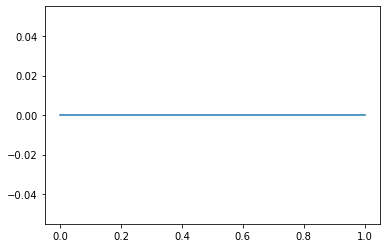

In [179]:
plt.plot(np.arange(len(losses)), losses)

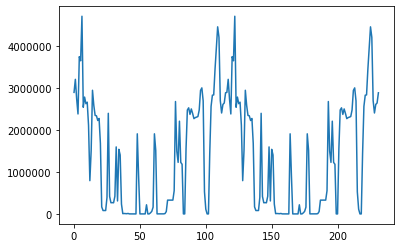

In [192]:
plt.plot(np.arange(len(bloss)), bloss)

# TEST

In [184]:
test_x, y_test = next((iter(traingen)))
print(test_x.shape, y_test.shape)
x = test_x.type(torch.FloatTensor).cuda()
print (x.type())
y_pred = mypredict(mymodel,x)
print(y_test, y_pred)

print("MSE {}".format(((y_test - y_pred)**2).sum()))

torch.Size([20, 200, 4]) torch.Size([20])
torch.cuda.FloatTensor
tensor([ 691.9070,  691.9070,  691.9070,  691.9070, 1251.2200, 1251.2200,
        1251.2200, 1515.3101, 1515.3101, 1146.3700, 1146.3700, 1294.2700,
        1294.2700, 1294.2700, 1294.2700, 1294.2700, 1294.2700, 1294.2700,
        1294.2700, 1294.2700], device='cuda:0') tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
MSE 578169344.0


# Data Analysis

In [185]:
import pandas as pd
import matplotlib.pyplot as plt

In [186]:
y_test, y_pred


(tensor([ 691.9070,  691.9070,  691.9070,  691.9070, 1251.2200, 1251.2200,
         1251.2200, 1515.3101, 1515.3101, 1146.3700, 1146.3700, 1294.2700,
         1294.2700, 1294.2700, 1294.2700, 1294.2700, 1294.2700, 1294.2700,
         1294.2700, 1294.2700], device='cuda:0'),
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]], device='cuda:0'))

In [187]:
y_test.cpu().numpy().flatten(), y_pred.cpu().numpy()

(array([ 691.907,  691.907,  691.907,  691.907, 1251.22 , 1251.22 ,
        1251.22 , 1515.31 , 1515.31 , 1146.37 , 1146.37 , 1294.27 ,
        1294.27 , 1294.27 , 1294.27 , 1294.27 , 1294.27 , 1294.27 ,
        1294.27 , 1294.27 ], dtype=float32),
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32))

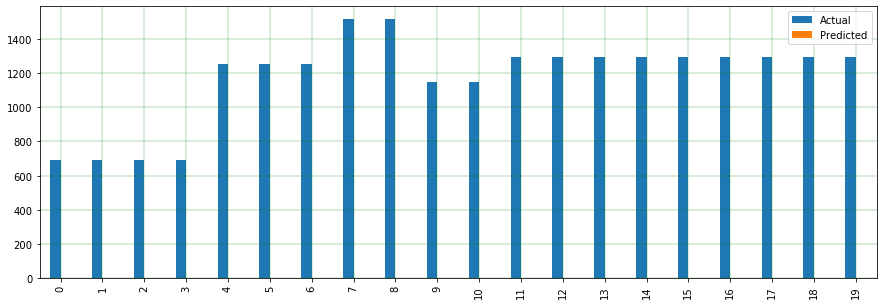

In [188]:
df2 = pd.DataFrame({'Actual': y_test.cpu().numpy().flatten(), 'Predicted': y_pred.cpu().numpy().flatten()})
df2.head()

df2.plot(kind='bar',figsize=(15,5))
plt.grid(which='major', linestyle='-', linewidth='0.3', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
plt.show()